In [2]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('vader_lexicon')
from IPython.display import display
import csv
import geopy
from pathlib import Path  
import sys
from bs4 import BeautifulSoup
import urllib
import json
import ast


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amer_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Authentication
consumerKey = "jLsJDtWU8yD5tZlcmwlzYnGjj"
consumerSecret = "Y236WRUhs5ylGfcZwjmabwPRWwedThHVB8gFVBPC3oTNAbRnCz"
accessToken = "964316780993933313-ZJOdE1MRMA8WyqZoNajtj0EWy4KQVDI"
accessTokenSecret = "qMOuqbyZmKXQTVXGFofwriLZpZn5zAAwGjsw0Wlft7M0a"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit = True)
file_dir = Path.cwd()

In [4]:

# The below function takes a given state, and returns a dataframe with every county and its corresponding square milage
def county_sqFootage(state):
	url = urllib.request.urlopen('http://www.usa.com/rank/' +state.lower() + '-state--land-area--county-rank.htm')
	path = url.read()
	# empty list
	data = []
	# for getting the header from
	# the HTML file
	list_header = []
	soup = BeautifulSoup((path),'html.parser')
	header = soup.find_all("table")[1].find("tr")
	for items in header:
		try:
			list_header.append(items.get_text())
		except:
			continue
	# for getting the data
	HTML_data = soup.find_all("table")[1].find_all("tr")[1:]
	for element in HTML_data:
		sub_data = []
		for sub_element in element:
			try:
				sub_data.append(sub_element.get_text())
			except:
				continue
		data.append(sub_data)

	# Storing the data into Pandas
	# DataFrame
	df = pd.DataFrame(data = data, columns = list_header)
	df.drop(df.columns[[0]],axis = 1,inplace = True)
	df.rename(columns = {'County / Population':'County','Land Area ▼':'Area'}, inplace = True)
	# Removing the section of the data for population information and deleting it
	formatdf= df['County'].str.split(',',expand = True)
	formatdf = formatdf[0]
	# recombining the data
	df = df['Area'].str.split(' sq', expand = True)
	df = df.replace({',':''}, regex=True)	
	df = df[0]
	df= pd.concat([df,formatdf],axis=1,join = 'inner')
	df.columns = ['Area','County']
	df['County']=df['County'].str.upper()
	df['Radius'] = df['Area'].astype(float)
	df['Radius'] = df['Radius'].apply(lambda x: (x/3.1415)**.5)
	# Search Radius is what the Twitter API will end up using
	return df	

	# Main code logic copied from Codegeeks https://www.geeksforgeeks.org/convert-html-table-into-csv-file-in-python/

print(county_sqFootage('Texas'))

        Area     County     Radius
0    6183.73   BREWSTER  44.366659
1    4763.84      PECOS  38.941265
2    4570.98   HUDSPETH  38.144869
3    3855.23   PRESIDIO  35.031329
4    3812.79  CULBERSON  34.837976
..       ...        ...        ...
249   251.98     MORRIS   8.956009
250   229.45      RAINS   8.546248
251   195.83       CAMP   7.895344
252   186.46  SOMERVELL   7.704143
253   127.04   ROCKWALL   6.359189

[254 rows x 3 columns]


In [5]:

def getCountyInfo(state):
    
    csv_folder = 'State information'
    file_path = os.path.join(file_dir, csv_folder, (state+'.csv'))
    print((Path.cwd() / csv_folder /(state+'.csv')).exists())    
    if((Path.cwd() / csv_folder /(state+'.csv')).exists()):
        data = pd.read_csv(file_path)
    else:
        print('boop')
        # make a program that uses this dataset https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv
        # to get all the cities in a state
        data = pd.read_csv('https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv',sep='|')
        del data['State short'], data['City'],data['City alias']
        data.columns = data.columns.str.replace('State full', 'State')
        data = data[data.State == state]
        data.drop_duplicates(subset='County', keep='first', inplace=True)
        del data['State']
        coordinates = []
        for county in data['County']:
            print(county)
            locator = geopy.Photon(user_agent="myGeocoder")
            location = locator.geocode(county.lower() + ',' + state + ', United States')
            # Make a new column in my dataframe with the lat and long
            coordinates.append([location.latitude,location.longitude])
        data['Coordinates'] = coordinates
        area = county_sqFootage(state)
        data = pd.merge(data,area, on= 'County', how = 'outer')
        data.rename(columns = {'Area':'Area (sq/mi)','Radius':'Radius (mi)'}, inplace = True)
        data.to_csv(file_path)
    return data

print(getCountyInfo('Texas'))

True
     Unnamed: 0     County                 Coordinates  Area (sq/mi)  \
0             0     TRAVIS   [30.2878569, -97.7561392]        990.20   
1             1    SHERMAN  [36.2452294, -101.8858689]        923.03   
2             2     DALLAS   [32.7762719, -96.7968559]        871.28   
3             3     COLLIN   [33.1609629, -96.6060984]        841.22   
4             4     DENTON   [33.1838787, -97.1413417]        878.43   
..          ...        ...                         ...           ...   
249         249    EL PASO   [31.7754152, -106.464634]       1012.69   
250         250   BREWSTER  [29.8462742, -103.2400734]       6183.73   
251         251   HUDSPETH  [31.5388627, -105.4752945]       4570.98   
252         252   PRESIDIO  [29.9883766, -104.2336552]       3855.23   
253         253  CULBERSON   [31.4622625, -104.482834]       3812.79   

     Radius (mi)  
0      17.753866  
1      17.141127  
2      16.653685  
3      16.363879  
4      16.721878  
..           ...

In [53]:
#Sentiment Analysis
def percentage(part,whole):
    return 100 * float(part)/float(whole)
noOfTweet = 100
state = 'Texas'
countyDF =  (getCountyInfo(state))
keyword = 'transgender'
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
cityDict = {}
json_folder = 'Keyword State'
file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
def average(arr):
    return (sum(arr) / len(arr))
# extract the county collumn from the countyDF and convert its values to a list
countyList = countyDF['County'].values.tolist()
usefulTweets = 0
users = []
county_needed = []
# if file_path exists, set the county_needed list equal to all the items from the county list not present in the keys of the json
total_data = []
if((Path.cwd() / json_folder /(((state) + " on the term " + keyword +'.json'))).exists()):
    f = open(file_path, 'r')
    cityDict = json.load(f)
    checked_counties = cityDict.keys()
    # set county_needed equal to the items in county that aren't present in checked_counties
    county_needed = countyList-checked_counties
    print(county_needed)
    for county in cityDict:
        tweet_list = tweet_list + cityDict[county][2]
    print(len(tweet_list))


else:
    county_needed = countyList
for county in county_needed:
    coordinates = (countyDF.loc[countyDF['County'] == county]['Coordinates'])
    coordinates = np.array(coordinates.values.tolist())[0]
    coordinates = ast.literal_eval(coordinates)
    lat = coordinates[0]
    longi = coordinates[1]
    miles = [countyDF.loc[countyDF['County'] == county]['Radius (mi)'].values[0]][0]
    geocode = str(coordinates[0]) + ',' + str(coordinates[1]) + ',' + str(miles) + 'mi'
    backoff_counter = 1
    while True:
        try:
            tweets = tweepy.Cursor(api.search_tweets, q=keyword,geocode = geocode).items(noOfTweet)
            break
        except tweepy.TweepError as e:
            print(e.reason)
            sleep(60*backoff_counter)
            backoff_counter += 1
            continue
    location = county
    tweet_list_county = []
    if location not in cityDict.keys():
        cityDict[location] = [1,[],[]]
    for tweet in tweets:
        # location = tweet.user.location
        
        username = tweet.user.id
        # location = (location.replace(', TX', '')).lower()
        cityDict[location][0]+=1
            
        tweet_list.append(tweet.text)
        analysis = TextBlob(tweet.text)
        score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
        neg = score['neg']
        neu = score['neu']
        pos = score['pos']
        comp = score['compound']
        if (username not in users) and (tweet not in tweet_list):
            tweet_list_county.append(tweet.text)
            usefulTweets+=1
            polarity += analysis.sentiment.polarity
            cityDict[location][1].append(polarity)
            if neg > pos:
                negative_list.append(tweet.text)
                negative += 1
            elif pos > neg:
                positive_list.append(tweet.text)
                positive += 1
            
            elif pos == neg:
                neutral_list.append(tweet.text)
                neutral += 1
            users.append(username)
            # Keep track of unique tweets per city
        cityDict[location][2].append(tweet_list_county)
        # save the cityDict to a json file at directory file_path
        with open(file_path, 'w') as fp:
            json.dump(cityDict, fp)
        
    print("For the county of " + str(county) + ", there were " + str(cityDict[location][0]) + " unique tweets")

for city in countyList:
    if(len(cityDict[city][1]) > 0):
        cityDict[city][1] = sum(cityDict[city][1])/len(cityDict[city][1])
    else:
        cityDict[city][0] = 0
        cityDict[city][1]= 0
        cityDict.pop(city)
    # delete the second index of cityDIct

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
# fully expand all lower levels of the list to the first level
tweet_list = [item for sublist in tweet_list for item in sublist]
print(len(tweet_list))

# make a new dictionary identical to countyDict but without the second index



True
{'BREWSTER'}
704
For the county of BREWSTER, there were 1 unique tweets
20286


In [54]:
print(cityDict)

{'TRAVIS': [57, 2.2269339994630695, [["@OldGreyHorror @thelovelymedusa @trulyaliem Them: Here's my fantasy shapeshifter character who has magic powers to… https://t.co/LX36kriKGK", "BELONGS ON A BILLBOARD:\n\n#RedNotice🚨 Texas Republicans! Y'all have wronged Texans in countless ways - letting our i… https://t.co/WKUtz7Bzgq", "@JimSterling Hey, it's important to be neutral on the debate of whether transgender people need to be exterminated or not.", '@SKiemel89 Well, you defended transgender, therefore racism', 'NEW: In murder trial of Chynal Lindsey, Ruben Alvarado  testifies that the two met on a dating app and then he kill… https://t.co/U7MUt9LzUs', '@mattyglesias I\'m on the "outsider left" I guess because I think transgender people are good and white privilege is… https://t.co/2xyjHqTAfW', '@youdamnskippy Transracial? Transgender would make more sense.', 'Trial begins in killing of Black transgender woman whose body was found in Dallas’ White Rock Lake   https://t.co/sWJM2pKdv1', "

In [ ]:

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')
print(cityDict)
print('---')
print(countyList.index('CHAMBERS'))
print(len(tweet_list))
# remove duplicates from tweet_list
tweet_list_duplicates = list(set(tweet_list))
print(len(tweet_list_duplicates))
# Function got too chambers before hitting rate limit

{'TRAVIS': [57, 2.642780404293562], 'DALLAS': [70, 7.178055233457022], 'COLLIN': [5, 9.780293921356423], 'DENTON': [4, 9.917293921356421], 'GRAYSON': [1, 10.892293921356421], 'ELLIS': [1, 11.09229392135642], 'KAUFMAN': [1, 11.09229392135642], 'HUNT': [1, 11.09229392135642], 'LAMAR': [1, 10.29229392135642], 'BOWIE': [1, 10.29229392135642], 'GREGG': [1, 10.29229392135642], 'SMITH': [3, 10.36155799062049], 'NACOGDOCHES': [2, 11.039371843434342], 'HOUSTON': [87, 13.631291208126703], 'ANGELINA': [2, 16.45973319504569], 'POLK': [6, 16.75190491221741], 'TARRANT': [19, 17.284628197703842], 'JOHNSON': [3, 17.89225003006252], 'HILL': [2, 17.916324104136596], 'CLAY': [44, 17.324887415824893], 'COOKE': [1, 17.756998707311194], 'ARCHER': [44, 17.1655620189995], 'BELL': [3, 16.25045108826357], 'CORYELL': [1, 17.014339977152456], 'MCLENNAN': [1, 17.469895532708012], 'WILLIAMSON': [4, 17.74489553270801], 'MILLS': [1, 18.06989553270801], 'TOM GREEN': [2, 18.06989553270801], 'HARRIS': [87, 20.4618148974

In [ ]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

total number:  70
positive number:  0
negative number:  0
neutral number:  0


In [ ]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(usefulTweets)

0  \
0   Dallas County jury finds man guilty of killing...   
1   Dallas County jury finds man guilty of killing...   
2   A Dallas County jury on Wednesday found Ruben ...   
3   Access to gender affirming health care can pro...   
4   @slygirlsnb He opened his mouth and spewed une...   
..                                                ...   
65  Mother of teen who raped female classmate says...   
66  @ItsStarDom @SapphicFail No need for the venom...   
67  Transgender Madness: Wisconsin School District...   
68  Supreme Court turns down Northern California C...   
69  @TrendingTeas but yall say transgender is wome...   

                                                 text  
0   dallas county jury finds man guilty of killing...  
1   dallas county jury finds man guilty of killing...  
2   a dallas county jury on wednesday found ruben ...  
3   access to gender affirming health care can pro...  
4     he opened his mouth and spewed uneducated an...  
..                                                ...  
65  mother of teen who raped female classmate says...  
66      no need for the venom   just pointing out ...  
67  transgender madness  wisconsin school district...  
68  supreme court turns down northern california c...  
69    but yall say transgender is women so    i me...  

[70 rows x 2 columns]

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
        tw_list.loc[index, 'neg'] = neg
        tw_list.loc[index, 'neu'] = neu
        tw_list.loc[index, 'pos'] = pos
        tw_list.loc[index, 'compound'] = comp
tw_list.head(10)
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [ ]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

Total  Percentage
negative      5       33.33
neutral       5       33.33
positive      5       33.33

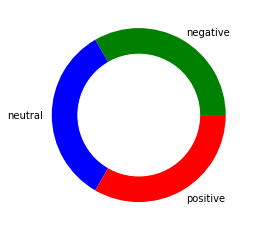

In [ ]:
# create data for Pie Chart
pc = count_values_in_column(tw_list,'sentiment')
names= pc.index
size=pc['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
def create_wordcloud(text):
    mask = np.array(Image.open('cloud.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


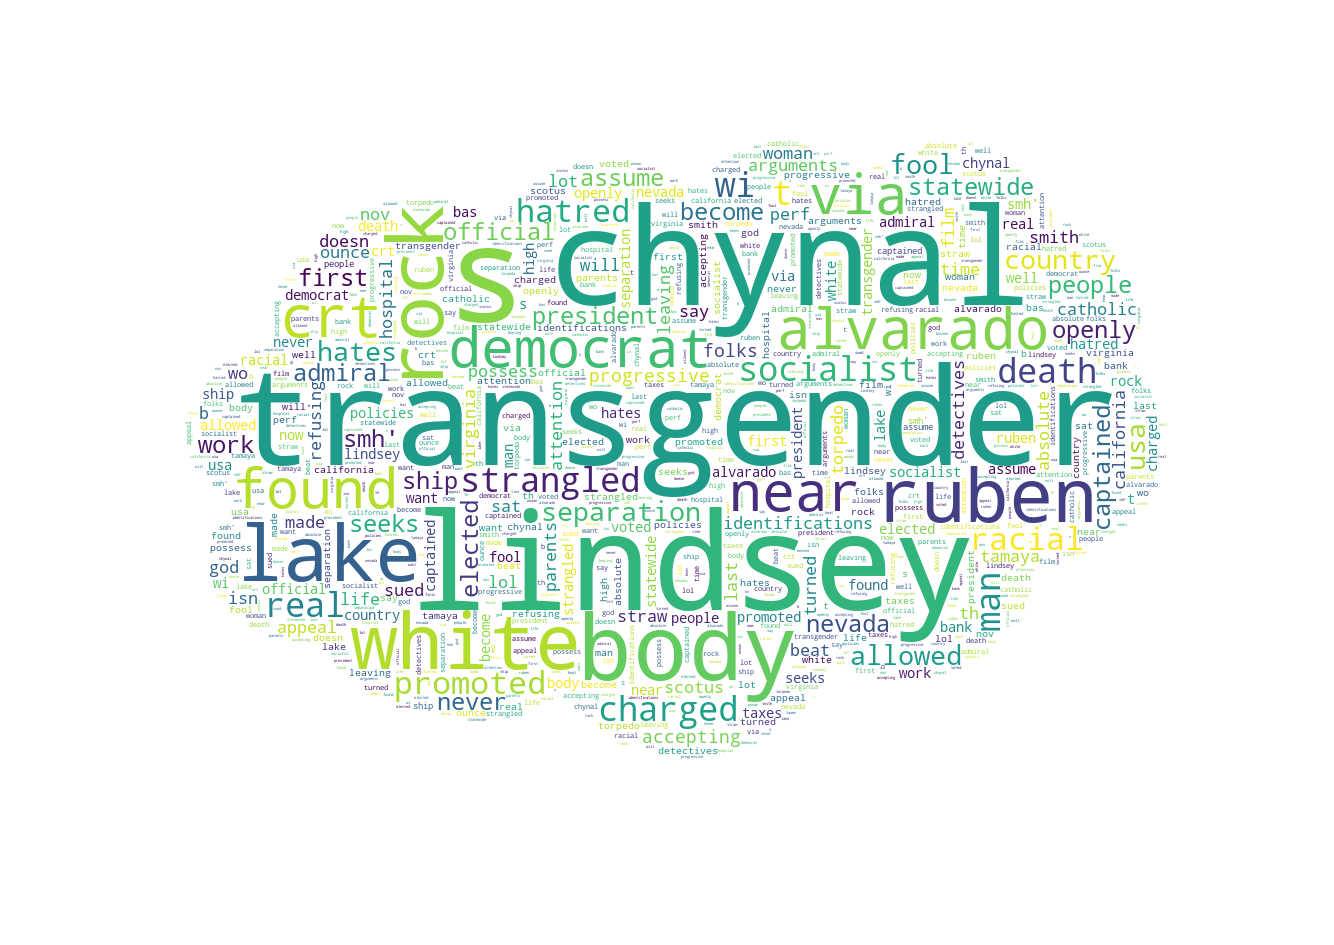

In [ ]:
create_wordcloud(tw_list['text'].values)

Word Cloud Saved Successfully


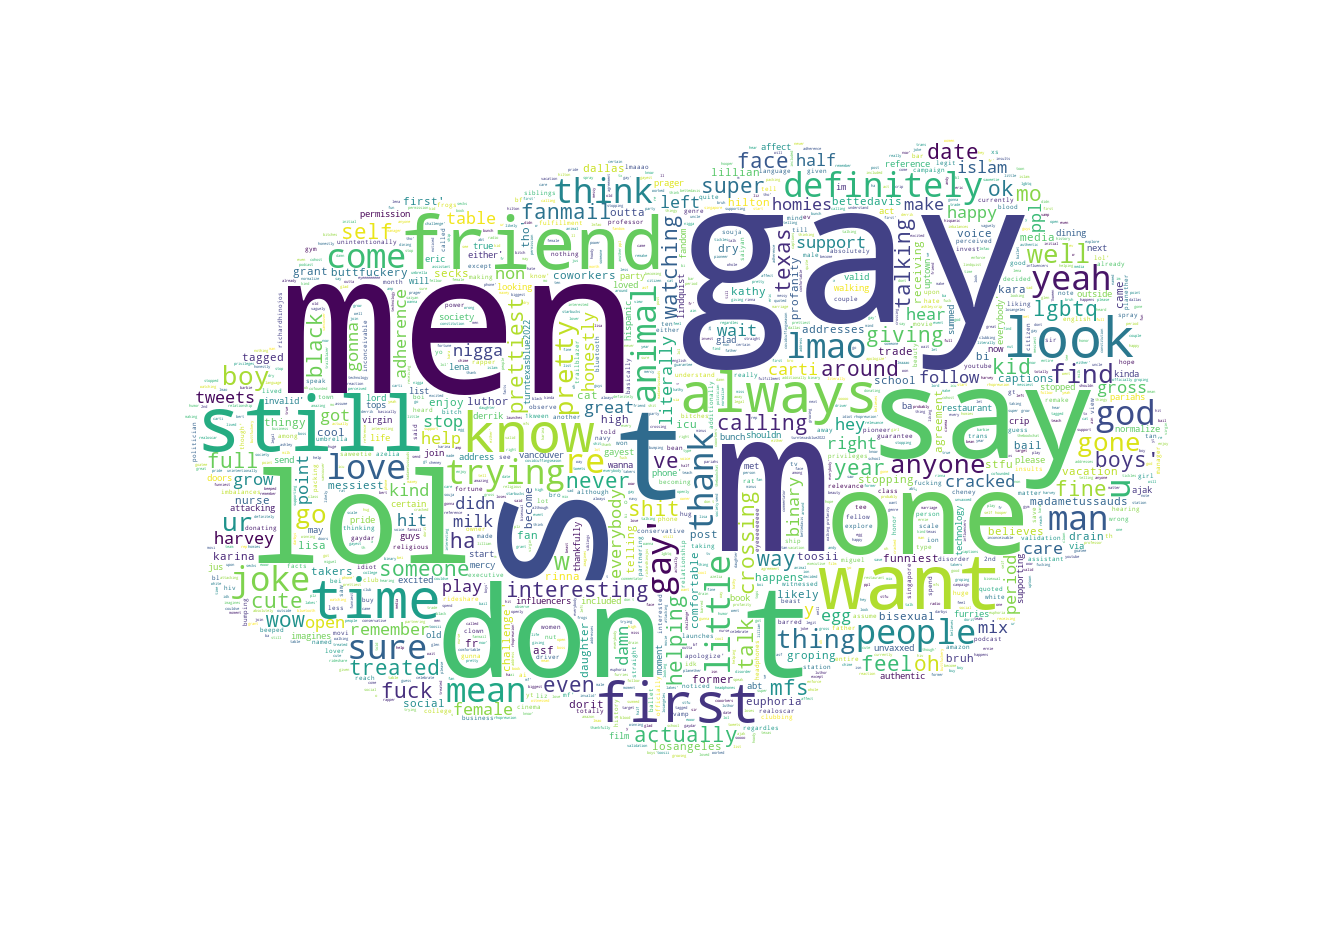

In [ ]:

#Creating wordcloud for positive sentiment
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


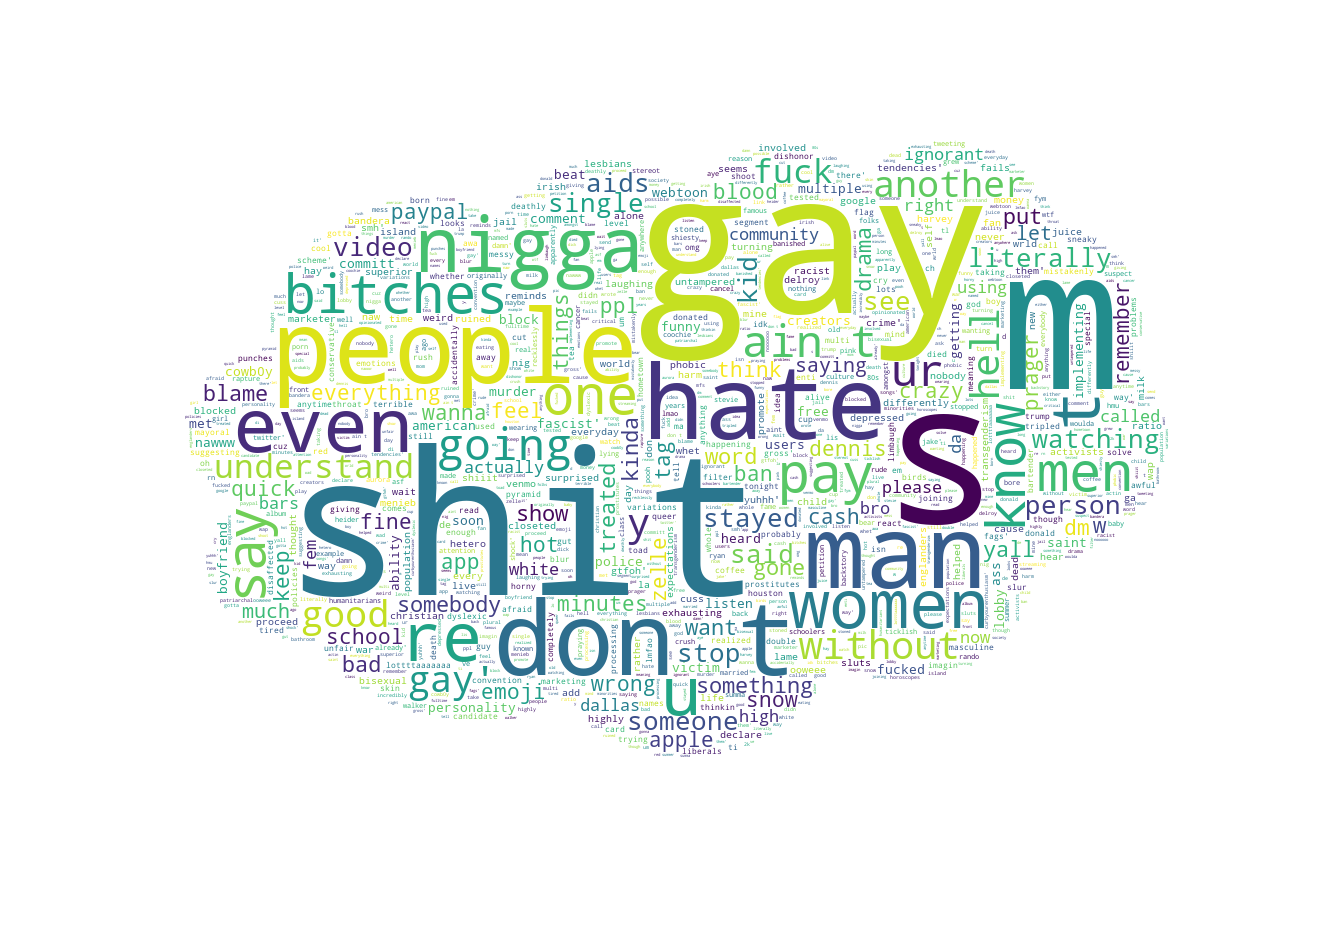

In [ ]:

#Creating wordcloud for negative sentiment
create_wordcloud(tw_list_negative["text"].values)

Word Cloud Saved Successfully


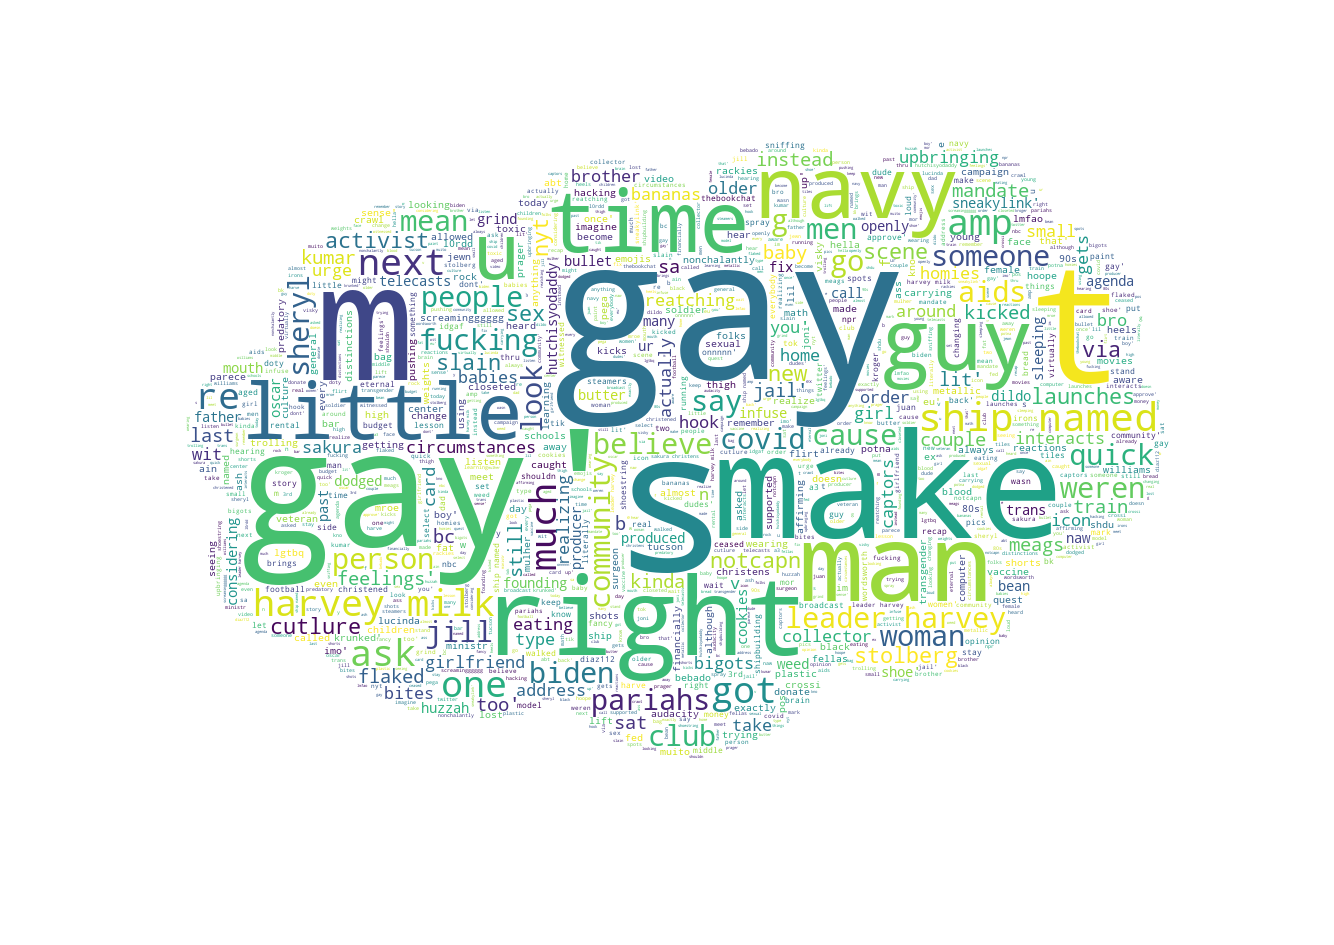

In [ ]:
#Creating wordcloud for neutral sentiment
create_wordcloud(tw_list_neutral["text"].values)